# The functionality of node2vec and the objective function

The node2vec functionality is illustrated.

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [48]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import networkx as nx

from sklearn.cluster import KMeans
from sklearn import metrics

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph 
from gensim.models import Word2Vec
# file with some visual functions 
from visual import *

In [3]:
# Global default values
dimensions = 128
walk_length = 80
num_walks = 10
p = 1.0
q = 1.0
workers = 4

window = 10
min_count = 1
seed = 42

## 1. Proof that the node2vec algorithm works on realy easy data

### $node2vec$ run
The function creating emedding models.

In [4]:
def count_embeddings(G,labels,dimensions,walk_length,num_walks,p,q,workers,window,min_count,seed):
    rw = BiasedRandomWalk(StellarGraph.from_networkx(G))
    weighted_walks = rw.run(
        nodes=G.nodes(), # root nodes
        length=walk_length,    # maximum length of a random walk
        n=num_walks,          # number of random walks per root node 
        p=p,         # Defines (unormalised) probability, 1/p, of returning to source node
        q=q,         # Defines (unormalised) probability, 1/q, for moving away from source node
        weighted=False, #for weighted random walks
        seed=42        # random seed fixed for reproducibility
    )
    print("Number of random walks: {}".format(len(weighted_walks)))
    
    # converting integers into string, otherwise Word2Vec throws an error 
    weighted_walks = [[str(j) for j in i] for i in weighted_walks]
    
    model = Word2Vec(weighted_walks, size=128, window=window, min_count=min_count, 
                     sg=1, workers=1, iter=1)
    
    model_nodes = list(model.wv.vocab)
    
    sorted_labels = []
    for i in model_nodes:
        sorted_labels.append(labels.loc[int(i)]['label'])

    return model,model_nodes,sorted_labels

### Data read and the graph visualisation
The data set consists of the 5 groups. Edges are only between nodes within a group. 

In [40]:
pure_edges = pd.read_csv('../data/clear_cluster_test/pure_edges.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label'))
labels_list = list(labels['label'].unique())

n_clusters = len(labels['label'].unique())

In [41]:
pure_G = nx.Graph()
pure_G.add_nodes_from(labels['node'])
for i, row in pure_edges.iterrows():
    pure_G.add_edge(row['from'],row['to'], weight=1)

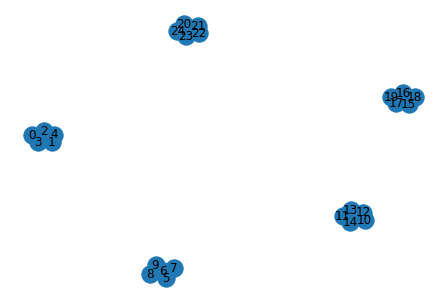

In [42]:
pos = nx.spring_layout(pure_G)
nx.draw(pure_G, pos=pos, with_labels=True, seed=seed)

### $node2vec$ model 

In [43]:
pure_model,pure_model_nodes,pure_sorted_labels = count_embeddings(pure_G,labels,dimensions,
                                                                  walk_length,num_walks,p,q,workers,
                                                                  window,min_count,seed)

Number of random walks: 250


Embeddings

In [44]:
pure_model.wv.vectors

array([[ 0.26363614,  0.12937744, -0.2792538 , ..., -0.03295454,
        -0.04424897, -0.19926961],
       [ 0.28906396,  0.12981641, -0.29150233, ..., -0.02912262,
        -0.04804998, -0.2105661 ],
       [ 0.24341209,  0.23137827, -0.19631234, ..., -0.04473389,
        -0.05347573, -0.1352158 ],
       ...,
       [ 0.34004784,  0.3725168 , -0.19099824, ..., -0.07431618,
        -0.07806014, -0.13893756],
       [ 0.24675766,  0.24772549, -0.17926362, ..., -0.04353056,
        -0.05180124, -0.12217439],
       [ 0.27296042,  0.14206755, -0.27709   , ..., -0.03694797,
        -0.05049235, -0.20382221]], dtype=float32)

### Clustretisation


#### Clusterization by $most\_similar()$ function
This step was made to show that the $node2vec$ algorithm works indeed.

In [45]:
keys = list(range(0,24,5)) # the first node of each group

embedding_clusters = []
word_clusters = []
for word in keys:
    print('word ',word)
    embeddings = []
    words = []
    embeddings.append(pure_model[str(word)]) # adding vector of the first(key) node
    words.append(str(word)) # adding vector of the first(key) node
    for similar_word, prob in pure_model.most_similar(str(word), topn=4): # или добавлять в зависимости от вероятности 
        words.append(similar_word)
        print(similar_word)
        embeddings.append(pure_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

word  0
3
4
1
2
word  5
9
7
8
6
word  10
13
14
11
12
word  15
17
18
19
16
word  20
23
24
22
21


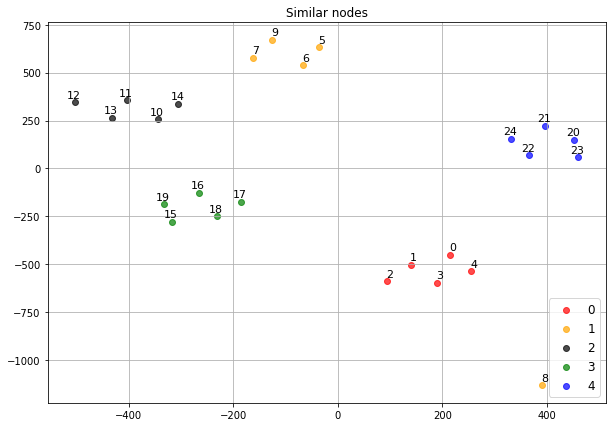

In [46]:
model_en_2d = to2d(embedding_clusters,5)
colors = assign_colors(pure_model_nodes,labels)
tsne_plot_similar_words('Similar nodes', labels_list, model_en_2d, word_clusters, colors, 0.7)

#### Clusterization by $kmeans$

In [12]:
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters=n_clusters, random_state=seed)
pure_idx = kmeans_clustering.fit_predict(pure_model.wv.vectors)
pure_word_centroid_map = dict(zip(pure_model.wv.index2word, pure_idx))

for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i in pure_word_centroid_map:
        if pure_word_centroid_map[i] == cluster:
            print(i)

cluster:  0
16
19
17
15
18
cluster:  1
11
13
10
12
14
cluster:  2
20
21
23
24
22
cluster:  3
2
3
0
4
1
cluster:  4
8
6
5
7
9


In [13]:
pure_known_labels = []
for i in pure_model.wv.index2word:
    pure_known_labels.append(labels.loc[int(i)]['label'])
    
pure_known_labels

[4, 4, 2, 1, 1, 2, 3, 0, 0, 3, 4, 0, 0, 3, 2, 1, 3, 3, 2, 1, 4, 1, 0, 2, 4]

In [14]:
pure_idx 

array([2, 2, 1, 4, 4, 1, 0, 3, 3, 0, 2, 3, 3, 0, 1, 4, 0, 0, 1, 4, 2, 4,
       3, 1, 2])

### A score to clasters assessing
The Rand index - $adjusted\_rand\_score()$

In [15]:
metrics.adjusted_rand_score([0,0,1,1,2,2],[1,1,0,0,2,2])

1.0

In [16]:
metrics.adjusted_rand_score([0,0,0,1,1,1],[0,0,1,1,1,1])

0.32432432432432434

In [17]:
pure_adj_score = metrics.adjusted_rand_score(pure_known_labels,pure_idx)
pure_adj_score

1.0

## 2. Run node2vec on more complex data

### Data read
Run on the test data. 

In [25]:
edges = pd.read_csv('../data/clear_cluster_test/one_eighth.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label'))
labels_list = list(labels['label'].unique())

n_clusters = len(labels['label'].unique())

The graph construction on the data

In [26]:
G = nx.Graph()
G.add_nodes_from(labels['node'])

for i, row in edges.iterrows():
    G.add_edge(row['from'],row['to'], weight=1)

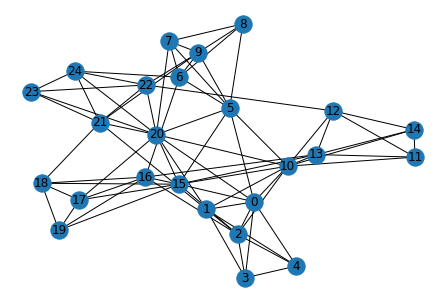

In [37]:
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels=True, seed=seed)

In [28]:
model, model_nodes, sorted_labels = count_embeddings(G,labels,dimensions,
                                                     walk_length,num_walks,p,q,workers,
                                                     window,min_count,seed)

Number of random walks: 250


In [29]:
# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters=n_clusters, random_state=seed)
idx = kmeans_clustering.fit_predict(model.wv.vectors)
word_centroid_map = dict(zip(model.wv.index2word, idx))

for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i in word_centroid_map:
        if word_centroid_map[i] == cluster:
            print(i)

cluster:  0
15
16
18
17
19
cluster:  1
14
11
cluster:  2
20
21
22
6
9
24
7
23
8
cluster:  3
10
13
12
cluster:  4
5
0
2
1
3
4


In [30]:
known_labels = []
for i in model.wv.index2word:
    known_labels.append(labels.loc[int(i)]['label'])
    
print(known_labels)

[4, 2, 3, 1, 0, 4, 3, 0, 0, 4, 2, 1, 1, 2, 3, 4, 1, 3, 2, 2, 4, 0, 1, 0, 3]


In [31]:
adj_score = metrics.adjusted_rand_score(known_labels,idx)
adj_score

0.625

## 3. Conclusions

- The $node2vec$ algorithm can detect the right groups of the nodes. 
- The Rand index score is suitable since it compares labels independently to the labels naming. 

